---

## Imports

In [1]:
import numpy as np 
from pathlib import Path 
import xarray as xr 
import tobac 
print('For this cookbook, we are using tobac version:', tobac.__version__)

For this cookbook, we are using tobac version: 1.6.0


### Look at the distribution to verify that thresholds make sense

In [2]:
# read in the regridded data (from previous step)
mpas_regridded = xr.open_dataset("mpas_ice_water_path_regridded.nc")

# read in the data into memory and change unit: g/m2 -> kg/m2
iwp = mpas_regridded.ice_water_path.compute() / 1000 

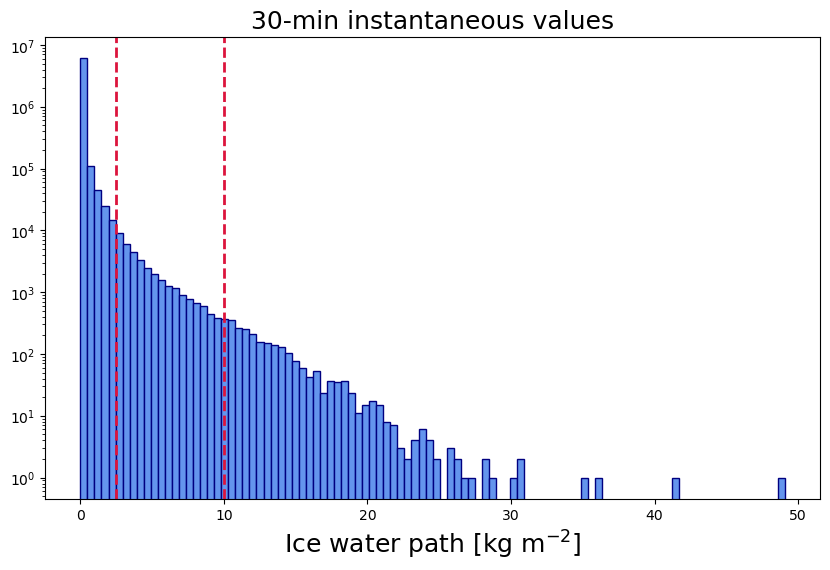

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

fs = 18
plt.title('30-min instantaneous values', fontsize = fs)
plt.hist(iwp.isel(time = 0).values.flatten(), bins=100, log=True, color='cornflowerblue', edgecolor='navy')

thresholds = [2.5, 10]
for threshold in thresholds:
    plt.axvline(x=threshold, color='crimson', linestyle='--', linewidth=2, label='Threshold' + str(threshold))

plt.xlabel('Ice water path [kg m$^{-2}$]', fontsize = fs )
plt.show()

## Feature detection

In [9]:
# set horizontal grid spacing [m] and temporal resolution [s]
dxy,dt= 14000, 3600 

# parameters for feature detection                                                           
parameters_features = {}
parameters_features['threshold']=[2.5, 10]  # thresholds for ice water path 
parameters_features['target']='maximum'
parameters_features['n_min_threshold']= 100  # minimum number of grid cells that need to be above specified threshold 

In [10]:
%%time 
input_data = iwp
storm_features = tobac.feature_detection_multithreshold(input_data, dxy, **parameters_features)

CPU times: user 603 ms, sys: 58.8 ms, total: 662 ms
Wall time: 2.34 s


## Segmentation 

In this step, we can calculate some bulk metrics for the storm objects detected in each timestep. 

In [11]:
# parameters for segmentation 
parameters_segmentation = {}
parameters_segmentation['threshold']= 0.25 # kg/m2 used to define the extent of the cloud objects                     
parameters_segmentation['target'] = "maximum"
parameters_segmentation['statistic'] = {"max_iwp": np.nanmax, 'total_iwp': np.nansum, 'mean_iwp': np.nanmean}

In [12]:
%%time 
mask, storm_features = tobac.segmentation_2D(storm_features, input_data, dxy, **parameters_segmentation)

CPU times: user 5.06 s, sys: 53.6 ms, total: 5.12 s
Wall time: 6.14 s


In [13]:
storm_features.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon,ncells,max_iwp,total_iwp,mean_iwp
0,0,2,234.340164,1250.975410,244,2.5,1,2020-07-01 10:00:00,2020-07-01 10:00:00,-66.565984,125.097541,16299,4.00023,14145.160156,0.867854
1,0,6,248.743961,646.578744,1035,2.5,2,2020-07-01 10:00:00,2020-07-01 10:00:00,-65.125604,64.657874,15836,4.644454,15395.15625,0.972162
2,0,14,277.795276,2828.803150,127,2.5,3,2020-07-01 10:00:00,2020-07-01 10:00:00,-62.220472,282.880315,7812,4.150726,5410.695312,0.692613
3,0,18,288.602740,689.808219,146,2.5,4,2020-07-01 10:00:00,2020-07-01 10:00:00,-61.139726,68.980822,5164,4.699671,4875.117188,0.944058
4,0,26,301.085714,1191.064286,140,2.5,5,2020-07-01 10:00:00,2020-07-01 10:00:00,-59.891429,119.106429,1299,6.078974,1489.626221,1.146748


### Computation of storm statistics 

One big advantage of global model data are the physically consistent fields. We can use **tobac** to calculate additional bulk statistics for the detected storm objects using other fields of the model data. 

In this example, we explore what the surface precipitation (*rainnc*) and liquid water path (*liquid_water_path*) are for the ice water path-based detected clouds. These two fields will tell us more about whether and how much it is raining underneath a cloud that produces lots of cloud ice and how the total amount of liquid condensate is related to the total amount of frozen condensate. 

In [13]:
# calculate statistics based on additional variables 
storm_features= tobac.utils.bulk_statistics.get_statistics_from_mask(
    storm_features, mask, mpas_regridded.liquid_water_path / 1000, statistic={"max_lwp": np.nanmax, "mean_lwp": np.nanmean, "total_lwp": np.nansum}, default=np.nan) 

storm_features = tobac.utils.bulk_statistics.get_statistics_from_mask(
    storm_features, mask, mpas_regridded.rainnc , statistic={"max_precip": np.nanmax, "mean_precip": np.nanmean, "total_precip": np.nansum}, default=np.nan) 

/glade/work/kukulies/conda-envs/easypeasy/lib/python3.12/site-packages/tobac/utils/bulk_statistics.py:340: UserWarning: Not all timesteps have matching features
  warnings.warn("Not all timesteps have matching features", UserWarning)
/glade/work/kukulies/conda-envs/easypeasy/lib/python3.12/site-packages/tobac/utils/bulk_statistics.py:340: UserWarning: Not all timesteps have matching features
  warnings.warn("Not all timesteps have matching features", UserWarning)


In [38]:
# save features
storm_features.to_xarray().to_netcdf('iwp_lwp_precip_features.nc')

## Tracking

In [17]:
# parameters for linking 
parameters_linking={}
parameters_linking['v_max']= 50
parameters_linking['stubs']= 1 
parameters_linking['method_linking']= 'predict'
parameters_linking['PBC_flag'] ="hdim_2"
parameters_linking['min_h2'] = 0 
parameters_linking['max_h2'] = mpas_regridded.lon.size

In [18]:
tracks = tobac.linking_trackpy(storm_features, None, dt=dt, dxy=dxy, **parameters_linking)

Frame 1: 46 trajectories present.


In [19]:
tracks.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon,ncells,max_iwp,total_iwp,mean_iwp,cell,time_cell
0,0,2,234.340164,1250.975410,244,2.5,1,2020-07-01 10:00:00,2020-07-01 10:00:00,-66.565984,125.097541,16299,4.00023,14145.160156,0.867854,1,0 days
1,0,6,248.743961,646.578744,1035,2.5,2,2020-07-01 10:00:00,2020-07-01 10:00:00,-65.125604,64.657874,15836,4.644454,15395.15625,0.972162,2,0 days
2,0,14,277.795276,2828.803150,127,2.5,3,2020-07-01 10:00:00,2020-07-01 10:00:00,-62.220472,282.880315,7812,4.150726,5410.695312,0.692613,3,0 days
3,0,18,288.602740,689.808219,146,2.5,4,2020-07-01 10:00:00,2020-07-01 10:00:00,-61.139726,68.980822,5164,4.699671,4875.117188,0.944058,4,0 days
4,0,26,301.085714,1191.064286,140,2.5,5,2020-07-01 10:00:00,2020-07-01 10:00:00,-59.891429,119.106429,1299,6.078974,1489.626221,1.146748,5,0 days


### Save tracking output (optional, but practical in most cases)

In [20]:
output_dir = Path('/') # change output directory according to your needs 

track_file_name = 'iwp_storm_tracks.nc'
mask_file_name = 'iwp_storm_mask.nc'

tracks.to_xarray().to_netcdf(track_file_name)
mask.to_netcdf(mask_file_name)

---